In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

train_batch_size = 100
test_batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
temp = torch.tensor(np.random.randint(0, 10, (len(trainset),)))
trainset.targets = temp.tolist()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=False)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
class CNN_Model1(nn.Module):
    def __init__(self):
        super(CNN_Model1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.bn1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.bn2(x)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = self.bn3(x)
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

class CNN_Model2(nn.Module):
    def __init__(self):
        super(CNN_Model2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.bn1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.bn2(x)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = self.bn3(x)
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

class CNN_Model3(nn.Module):
    def __init__(self):
        super(CNN_Model3, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256, 512)  
        self.fc2 = nn.Linear(512, 10)   

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = F.avg_pool2d(x, x.size()[2:])  
        x = x.view(x.size(0), -1)  
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [7]:
def train_and_evaluate_model(model, train_loader, test_loader, optimizer, criterion, epochs):
    model.train()
    train_losses, test_losses, accuracies = [], [], []

    for epoch in range(epochs):
        total_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_test_loss = 0.0
        total_correct = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                total_test_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1, keepdim=True)
                total_correct += preds.eq(labels.view_as(preds)).sum().item()

        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        accuracies.append(total_correct / len(test_loader.dataset))

        print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracies[-1]:.4f}')

    return train_losses, test_losses, accuracies

In [8]:
model1 = CNN_Model1()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)
print("Training Model 1:")
train_losses_1, test_losses_1, accuracies_1 = train_and_evaluate_model(model1, trainloader, testloader, optimizer, loss_func, epochs=15)

model2 = CNN_Model2()
optimizer = optim.Adam(model2.parameters(), lr=0.001)
print("\nTraining Model 2:")
train_losses_2, test_losses_2, accuracies_2 = train_and_evaluate_model(model2, trainloader, testloader, optimizer, loss_func, epochs=15)

model3 = CNN_Model3()
optimizer = optim.Adam(model3.parameters(), lr=0.001)
print("\nTraining Model 3:")
train_losses_3, test_losses_3, accuracies_3 = train_and_evaluate_model(model3, trainloader, testloader, optimizer, loss_func, epochs=15)

Training Model 1:
Epoch 1, Train Loss: 2.3200, Test Loss: 2.3105, Accuracy: 0.1071
Epoch 2, Train Loss: 2.3015, Test Loss: 2.3079, Accuracy: 0.1103
Epoch 3, Train Loss: 2.2954, Test Loss: 2.3256, Accuracy: 0.0896
Epoch 4, Train Loss: 2.2834, Test Loss: 2.3366, Accuracy: 0.0962
Epoch 5, Train Loss: 2.2601, Test Loss: 2.3670, Accuracy: 0.0866
Epoch 6, Train Loss: 2.2152, Test Loss: 2.4146, Accuracy: 0.0830
Epoch 7, Train Loss: 2.1523, Test Loss: 2.4636, Accuracy: 0.0987
Epoch 8, Train Loss: 2.0769, Test Loss: 2.5031, Accuracy: 0.1062
Epoch 9, Train Loss: 2.0038, Test Loss: 2.5462, Accuracy: 0.1018
Epoch 10, Train Loss: 1.9494, Test Loss: 2.6021, Accuracy: 0.0987
Epoch 11, Train Loss: 1.8826, Test Loss: 2.7029, Accuracy: 0.0973
Epoch 12, Train Loss: 1.8320, Test Loss: 2.7766, Accuracy: 0.0975
Epoch 13, Train Loss: 1.7863, Test Loss: 2.8225, Accuracy: 0.1036
Epoch 14, Train Loss: 1.7485, Test Loss: 2.9889, Accuracy: 0.1006
Epoch 15, Train Loss: 1.7130, Test Loss: 3.0855, Accuracy: 0.0974



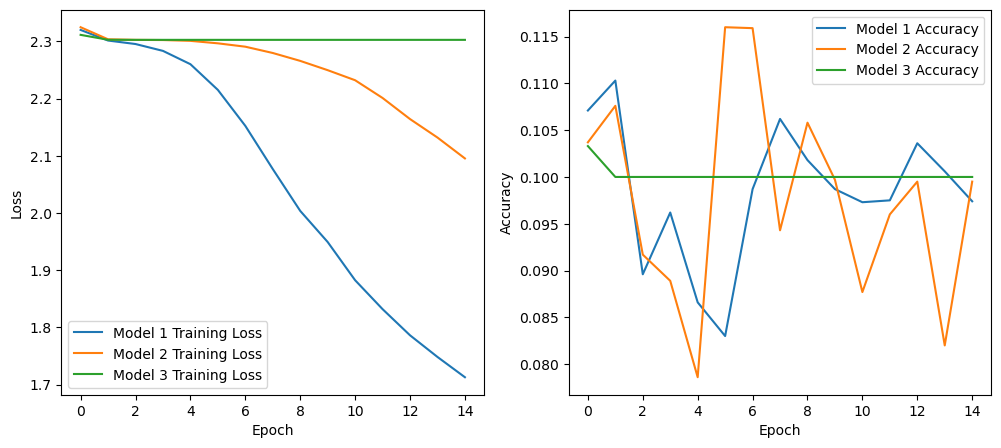

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_1, label='Model 1 Training Loss')
plt.plot(train_losses_2, label='Model 2 Training Loss')
plt.plot(train_losses_3, label='Model 3 Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies_1, label='Model 1 Accuracy')
plt.plot(accuracies_2, label='Model 2 Accuracy')
plt.plot(accuracies_3, label='Model 3 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
